<a href="https://colab.research.google.com/github/Pradn1l/Predicting-Rain-in-Austrailia-NN/blob/main/PredictingRainNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prediciting if it would rain in Austrailia 

*   Inspired and learned from Venelin Valkov vlog
*   Author of the notebook: Pradnil S Kamble



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from torch import nn, optim
import torch
import torch.nn.functional as F
from tqdm import tqdm

gdown is to download the CSV file from the drive link





In [ ]:
!gdown --id 1Q1wUptbNDYdfizk5abhmoFxIQiX19Tn7

Downloading...
From: https://drive.google.com/uc?id=1Q1wUptbNDYdfizk5abhmoFxIQiX19Tn7
To: /content/weatherAUS.csv
14.2MB [00:00, 45.0MB/s]


In [ ]:
#read the data into a data frame 
ds = pd.read_csv('weatherAUS.csv')

Some of the data are NAN (missing) which could be a problem later on. Also we could change certain strings to the numebrs yes and no to 0 and 1. 
This we do during the preprocessing.

In [ ]:
ds.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


Our data contains 24 columns.. too much.. we truncate

In [ ]:
ds.shape

(142193, 24)

Data preprocessing

*   check missing values in columns (truncate the one with most missing values)



In [ ]:
ds.isna().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

Create data columns for training model based on feature selection of impotant columns based on correlation techniques



In [ ]:
colms = ['Rainfall', 'Humidity3pm', 'Pressure9am','RainToday', 'RainTomorrow']
ds = ds[colms]

In [ ]:
ds.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


Replace No with 0 and yes with 1

In [ ]:
ds['RainToday'].replace({'No': 0, 'Yes':1}, inplace = True)
ds['RainTomorrow'].replace({'No': 0, 'Yes':1}, inplace = True)

In [ ]:
ds.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0.0,0
1,0.0,25.0,1010.6,0.0,0
2,0.0,30.0,1007.6,0.0,0
3,0.0,16.0,1017.6,0.0,0
4,1.0,33.0,1010.8,0.0,0


Drop every word that may have the missing value (not the best way yet can work)


In [ ]:
ds = ds.dropna(how='any')
ds.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0.0,0
1,0.0,25.0,1010.6,0.0,0
2,0.0,30.0,1007.6,0.0,0
3,0.0,16.0,1017.6,0.0,0
4,1.0,33.0,1010.8,0.0,0


we lost 10% of data (no prob)

In [ ]:
ds.shape

(124689, 5)

number of examples that it would really rain vs it wont rain. The data spread looks really bad we have less Yes compared to No

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


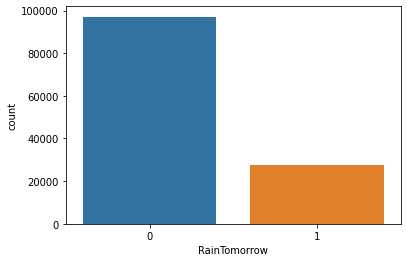

In [ ]:
sns.countplot(ds.RainTomorrow)

See percentage

In [ ]:
ds.RainTomorrow.value_counts() / ds.shape[0]

0    0.778762
1    0.221238
Name: RainTomorrow, dtype: float64

Big proble because we need enough data from each class. Roughly equal so out model can learn.
Guide to solve this: https://curiousily.com/posts/practical-guide-to-handling-imbalanced-datasets/

Create features for now: Extract the labels or target variables the y's. To do that take subsets

In [ ]:
from  sklearn.model_selection import train_test_split
x = ds[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = ds['RainTomorrow']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state = 0)

Final step of data preprocessing is to convert all those nupy arrays (panda frames) to torch tensors (to work with torch)
torch from numpy to tensor of numpy. Then convert all of that to float tensor.

In [ ]:
y_train.shape

(99751,)

In [ ]:
x_train = torch.from_numpy(x_train.to_numpy()).float()
x_test = torch.from_numpy(x_test.to_numpy()).float()

#we remove the extra dimension that the ytrain has ,1
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())


We have exact number of rows hence good. 4 features as x (input) and 1 feature as y output. 



In [ ]:
print(x_train.shape, y_train.shape)

torch.Size([99751, 4]) torch.Size([99751])


Build **Neural Networks**

*   Will take in 4 features and output a single value
*   One way is to extend the pytorch nnextension. Class Net is an extension of our nn module



In [ ]:
class Net(nn.Module):

# 1) constructor (which has input, hidden and output layers)
  def __init__(self,n_feature):
    super(Net, self).__init__()
    # we are defining 3 layers
    self.fc1 = nn.Linear(n_feature, 5) # input layer with 5 output features
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)  # Output layer with 1 output rain yes or no

# put this x through each layer of the net
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    #return result
    return torch.sigmoid(self.fc3(x))


In [ ]:
net = Net(x_train.shape[1])

#Optimization

*   Loss function: BCE Binary cross entropy loss: measures the difference between two binary vectors, tells how much two prob distribution differ, it can only handle binary that is 2 distribution, rain yes or not. It accepts the input as a output of a sigmoid function
*   Training


In [ ]:
#Criteria to see how good are we doing, we try to get loss 0
criterion = nn.BCELoss()

In [ ]:
# Optimizer tries to get our function close to zero, there are many available, some are better than others. 
# The best is Adam Optimizer: Safe optimizer, doesnt blow off
# from torch import Optim, most important is param (param of our nn) default value of lr learning rate = 0.001
# Try to find learning rate based on iterations 
optimizer = optim.Adam(net.parameters(), lr=0.001)


**GPU Acceleration**
Training on GPU can speed up the process. Whenever dealing with large corpus choose to train on GPU. Not all GPUs only the ones for NN, maybe nvidia or googlecolab, aws. Current one is Tesla T4 which is really good.

In [ ]:
!nvidia-smi

Mon Dec 14 23:35:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

How you can convert the training data and use it on GPU. Just first check if your machine has cuda, which is ingeneral the software that does most of the calculations

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else CPU)

Then transform all the data from RAM to GPU Memory

In [ ]:
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [ ]:
!nvidia-smi

Tue Dec 15 00:00:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W /  70W |    971MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Convert the model and the loss function to the GPU as well 

In [ ]:
net = net.to(device)
criterion = criterion.to(device)

#Training

In [ ]:
def calculate_accuracy(y_real, y_hat):
  # anything less than 0.5 make it 0 and anything greater than that make it 1
  predicted = y_hat.ge(.5).view(-1)
  return (y_real == predicted).sum().float() / len(y_real)

Using pytorch pretty easy

In [ ]:
x_test.shape

torch.Size([24938, 4])

In [ ]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1000):
    
    y_pred = net(x_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(x_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')

    optimizer.zero_grad()

    train_loss.backward()
    
    optimizer.step()

epoch 0
Train set - loss: 17.453, accuracy: 0.779
Test  set - loss: 17.647, accuracy: 0.777

epoch 100
Train set - loss: 17.453, accuracy: 0.779
Test  set - loss: 17.647, accuracy: 0.777

epoch 200
Train set - loss: 17.453, accuracy: 0.779
Test  set - loss: 17.647, accuracy: 0.777

epoch 300
Train set - loss: 17.453, accuracy: 0.779
Test  set - loss: 17.647, accuracy: 0.777

epoch 400
Train set - loss: 17.453, accuracy: 0.779
Test  set - loss: 17.647, accuracy: 0.777

epoch 500
Train set - loss: 17.453, accuracy: 0.779
Test  set - loss: 17.647, accuracy: 0.777

epoch 600
Train set - loss: 17.453, accuracy: 0.779
Test  set - loss: 17.647, accuracy: 0.777

epoch 700
Train set - loss: 17.453, accuracy: 0.779
Test  set - loss: 17.647, accuracy: 0.777

epoch 800
Train set - loss: 17.453, accuracy: 0.779
Test  set - loss: 17.647, accuracy: 0.777

epoch 900
Train set - loss: 17.453, accuracy: 0.779
Test  set - loss: 17.647, accuracy: 0.777

